In [1]:
import os # type: ignore
import sys # type: ignore
import numpy as np # type: ignore
import matplotlib.pyplot as plt # type: ignore
import seaborn as sns #type: ignore

from tqdm import tqdm # type: ignore

import torch # type: ignore
import torch.nn as nn # type: ignore
import torch.nn.functional as F # type: ignore
import torch.optim as optim # type: ignore
from torch.utils.data import Dataset, DataLoader # type: ignore

from sklearn.metrics import accuracy_score, confusion_matrix # type: ignore
from sklearn.model_selection import train_test_split # type: ignore

import uproot as ur # type: ignore
import pickle # type: ignore
import pandas as pd # type: ignore

print("System Platform: ", sys.platform)
print('System Python Version:', sys.version)
print('PyTorch version', torch.__version__)
print('Numpy version', np.__version__)

System Platform:  linux
System Python Version: 3.10.16 | packaged by conda-forge | (main, Dec  5 2024, 14:16:10) [GCC 13.3.0]
PyTorch version 2.6.0
Numpy version 2.1.3


# Preliminary Data Manipulation

In [2]:
X, y = None, None
pickled_data_file_path = "transformed_data.pkl"
pickled_labels_file_path = "transformed_labels.pkl"
if os.path.exists(pickled_data_file_path) and os.path.exists(pickled_labels_file_path):
    with open(pickled_data_file_path, 'rb') as f:
        X = pickle.load(f)
    with open(pickled_labels_file_path, 'rb') as f:
        y = pickle.load(f)

In [3]:
if X is None or y is None:
    background_data_file_name = "train_bkg_data_sideBands_lowQ_wPreselBDT_v5.root"
    signal_data_file_name = "train_sig_rare_lowQ_wPreselBDT_v6.root"

    background_data_file = ur.open(background_data_file_name)
    signal_data_file = ur.open(signal_data_file_name)
    features = ['Bprob', 'BsLxy', 'L2iso/L2pt', 'Bcos', 'Kiso/Kpt', 'LKdz', 'LKdr', 'Passymetry', 'Kip3d/Kip3dErr', 'L1id', 'L2id']
    sample_weights = 'trig_wgt'
    preselection = '(KLmassD0 > 2.) & ((Mll>1.05) & (Mll<2.45))'

    sig_dict = signal_data_file['mytree'].arrays(features, library='np', cut=preselection)
    bkg_dict = background_data_file['mytree'].arrays(features, library='np', cut=preselection)
    backgr = np.stack(list(bkg_dict.values()))
    signal = np.stack(list(sig_dict.values()))

    X = np.transpose(np.concatenate((signal, backgr), axis=1))
    y = np.concatenate((np.ones(signal.shape[1]), np.zeros(backgr.shape[1])))

    with open(pickled_data_file_path, 'wb') as f:
        pickle.dump(X, f)
    with open(pickled_labels_file_path, 'wb') as f:
        pickle.dump(y, f)

# Dataset Analysis

In [4]:
def plot_event_distribution(df: pd.DataFrame, title: str, axis = None):
    if axis is None:
        _, ax = plt.subplots(1,1, figsize=(7,7))
    else: 
        ax = axis
    counts, _, patches = ax.hist(df['Label'], bins=2)
    ax.set_xticks([0, 1])
    ax.set_xticklabels(["Background", "Signal"])
    ax.set_yticks([counts[0], counts[1]])
    patches[0].set_facecolor('royalblue') 
    patches[1].set_facecolor('mediumseagreen')
    ax.set_title(f"Signal Events V.S. Background Events: {title}")
    if axis is None:
        plt.show()

def plot_event_distribution_np(array: np.ndarray, title: str, axis = None):
    if axis is None:
        _, ax = plt.subplots(1,1, figsize=(7,7))
    else: 
        ax = axis
    counts, _, patches = ax.hist(array, bins=2)
    ax.set_xticks([0, 1])
    ax.set_xticklabels(["Background", "Signal"])
    ax.set_yticks([counts[0], counts[1]])
    patches[0].set_facecolor('royalblue') 
    patches[1].set_facecolor('mediumseagreen')
    ax.set_title(f"Signal Events V.S. Background Events: {title}")
    if axis is None:
        plt.show()

In [5]:
random_seed = 89235

total_df = pd.DataFrame(np.column_stack((X, y)), columns=['Bprob', 'BsLxy', 'L2iso/L2pt', 'Bcos', 'Kiso/Kpt', 'LKdz', 'LKdr', 'Passymetry', 'Kip3d/Kip3dErr', 'L1id', 'L2id','Label'])

background_df = total_df[total_df['Label'] == 0]
signal_df = total_df[total_df['Label'] == 1]

undersample_count = int(len(background_df) * 0.60)
background_undersampled_df = background_df.sample(n=undersample_count, random_state=random_seed)

under_sampled_df = pd.concat([background_undersampled_df, signal_df], axis=0)
under_sampled_df = under_sampled_df.sample(frac=1, random_state=42).reset_index(drop=True)
under_sampled_df.head(20)

,Bprob,BsLxy,L2iso/L2pt,Bcos,Kiso/Kpt,LKdz,LKdr,Passymetry,Kip3d/Kip3dErr,L1id,L2id,Label
0,0.133331,0.679944,3.034437,0.862647,12.155849,0.046875,1.153008,0.690178,-2.046985,0.197764,-3.070724,0.0
1,0.325459,1.141071,1.047036,-0.826137,20.317356,0.006836,0.831238,0.940076,-1.618662,-4.265243,2.099060,0.0
2,0.841110,1.076948,2.166431,-0.987630,10.237161,0.000000,1.055932,0.415504,-0.853911,-0.797323,-0.576801,0.0
3,0.670958,0.482797,2.957580,-0.153510,7.854008,0.003906,1.362927,0.836665,-1.142456,-0.618597,-1.789464,0.0
4,0.957789,1.522316,1.973161,0.649583,7.565304,0.015625,1.345184,0.872898,-0.341958,0.700328,1.488709,0.0
5,0.263437,1.210586,9.204399,-0.992655,23.544544,0.015625,1.472339,0.759144,-0.762605,2.759261,-1.373631,0.0
6,0.145320,1.163486,2.062042,0.984581,24.445423,0.066406,0.933366,0.409283,-2.005699,-5.525388,0.283013,0.0
7,0.004030,2.345824,4.152372,-0.998907,43.040977,0.210938,1.453203,-0.443563,-3.535489,0.876472,-0.500205,0.0
8,0.045746,1.113422,3.088919,-0.863295,22.877907,0.023438,0.814385,0.927704,-1.967839,2.104617,1.374729,0.0
9,0.467744,1.285200,2.129013,0.999039,9.275366,0.013672,0.587517,0.534815,1.262315,-2.232447,-1.826885,0.0


In [6]:
X_undersampled = under_sampled_df.drop(columns='Label').to_numpy()
y_undersampled = under_sampled_df["Label"].to_numpy()

X_u_train, X_u_temp, y_u_train, y_u_temp = train_test_split(X_undersampled, y_undersampled, test_size=0.3, random_state=random_seed)
X_u_val, X_u_test, y_u_val, y_u_test = train_test_split(X_u_temp, y_u_temp, test_size=0.5, random_state=random_seed)

X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.3, random_state=random_seed)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=random_seed)

training_df = pd.DataFrame(np.column_stack((X_train, y_train)), columns=['Bprob', 'BsLxy', 'L2iso/L2pt', 'Bcos', 'Kiso/Kpt', 'LKdz', 'LKdr', 'Passymetry', 'Kip3d/Kip3dErr', 'L1id', 'L2id','Label'])
valid_df = pd.DataFrame(np.column_stack((X_val, y_val)), columns=['Bprob', 'BsLxy', 'L2iso/L2pt', 'Bcos', 'Kiso/Kpt', 'LKdz', 'LKdr', 'Passymetry', 'Kip3d/Kip3dErr', 'L1id', 'L2id','Label'])
test_df = pd.DataFrame(np.column_stack((X_test, y_test)), columns=['Bprob', 'BsLxy', 'L2iso/L2pt', 'Bcos', 'Kiso/Kpt', 'LKdz', 'LKdr', 'Passymetry', 'Kip3d/Kip3dErr', 'L1id', 'L2id','Label'])

print("W/o Undersampling:")
print(f"Training set: {X_train.shape}")
print(f"Validation set: {X_val.shape}")
print(f"Test set: {X_test.shape}")
print("---------------------------------------------------\n")
print("W/ Undersampling:")
print(f"Training set: {X_u_train.shape}")
print(f"Validation set: {X_u_val.shape}")
print(f"Test set: {X_u_test.shape}")

W/o Undersampling:
Training set: (2553918, 11)
Validation set: (547268, 11)
Test set: (547269, 11)
---------------------------------------------------

W/ Undersampling:
Training set: (1547761, 11)
Validation set: (331663, 11)
Test set: (331664, 11)


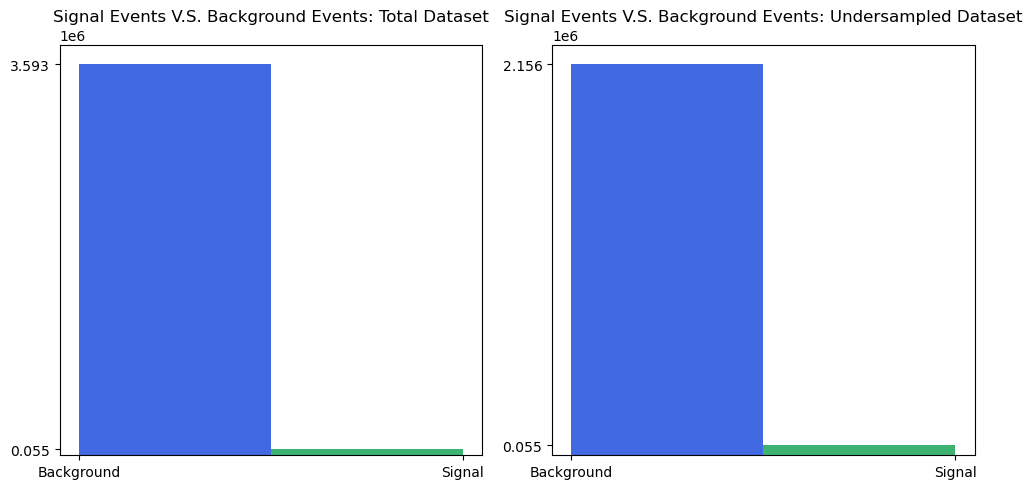

In [7]:

fig, axs = plt.subplots(1, 2, figsize=(10,5))
plot_event_distribution(total_df, "Total Dataset", axs[0])
plot_event_distribution(under_sampled_df, "Undersampled Dataset", axs[1])
plt.tight_layout()
plt.show()

Data Distribution Without Undersampling


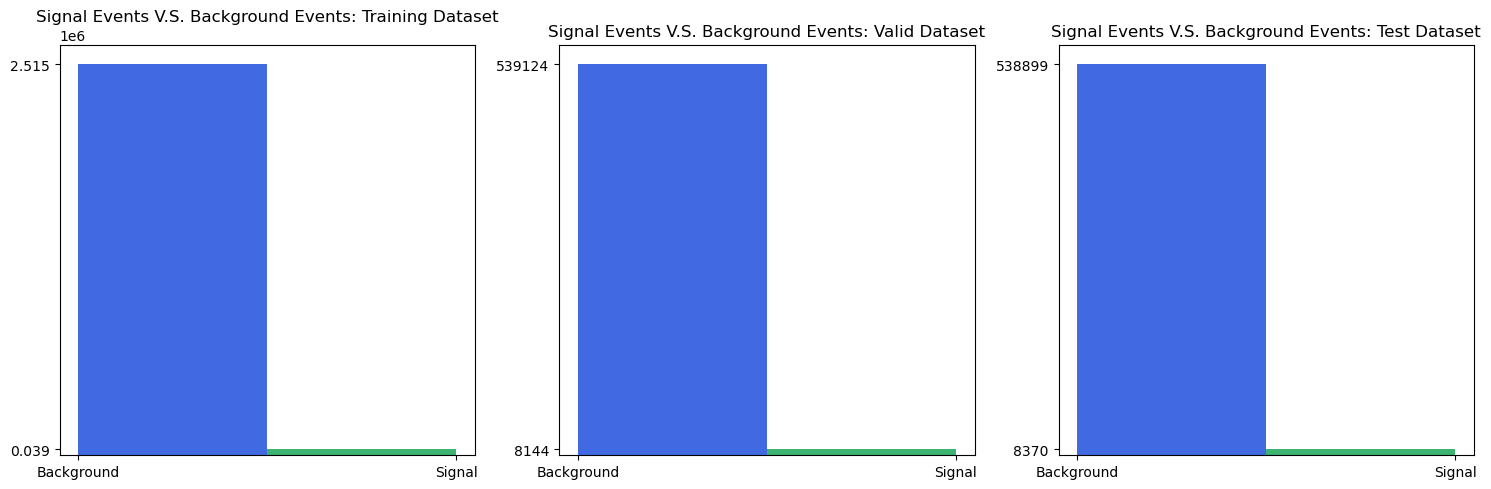

----------------------------------------------------
Data Distribution With Undersampling


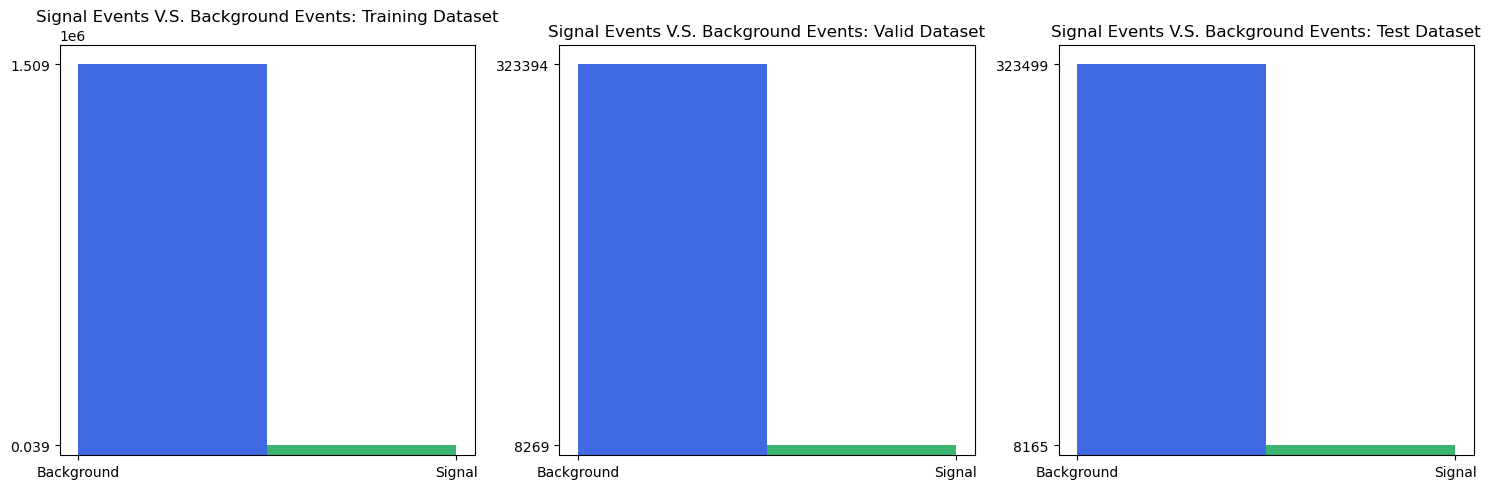

In [8]:
print("Data Distribution Without Undersampling")
fig, axs = plt.subplots(1, 3, figsize=(15,5))
plot_event_distribution(training_df, "Training Dataset", axs[0])
plot_event_distribution(valid_df, "Valid Dataset", axs[1])
plot_event_distribution(test_df, "Test Dataset", axs[2])
plt.tight_layout()
plt.show()
print("----------------------------------------------------")
print("Data Distribution With Undersampling")
fig, axs = plt.subplots(1, 3, figsize=(15,5))
plot_event_distribution_np(array=y_u_train, title="Training Dataset", axis=axs[0])
plot_event_distribution_np(array=y_u_val, title="Valid Dataset", axis=axs[1])
plot_event_distribution_np(array=y_u_test, title="Test Dataset", axis=axs[2])
plt.tight_layout()
plt.show()

# Dataset & DataLoader Instantiation

In [9]:
class Transform:
    def __call__(self, data: np.ndarray):
        return data

class Normalize(Transform):
    def __call__(self, data: np.ndarray):
        data = data.astype(np.float64)

        min_values = np.min(data, axis=0)
        max_values = np.max(data, axis=0)

        data -= min_values
        data /= (max_values - min_values)

        return data


In [10]:
class ParticlesDataset(Dataset):
    def __init__(self, data: np.ndarray, labels: np.ndarray, transform: Transform = Transform()):
        if data.shape[0] != labels.shape[0]:
            raise RuntimeError("Training data and training labels have size mismatch:", self.__class__.__name__)
        
        self.data = torch.tensor(transform(data), dtype=torch.float32)
        self.labels = torch.tensor(labels, dtype=torch.long)

    def __len__(self):
        return self.data.shape[0]
    
    def __getitem__(self, index):
        return (self.data[index], self.labels[index])
    
    @property
    def classes(self):
        return ['Background', 'Signal']
    
    @property
    def features(self):
        return ['Bprob', 'BsLxy', 'L2iso/L2pt', 'Bcos', 'Kiso/Kpt', 'LKdz', 'LKdr', 'Passymetry', 'Kip3d/Kip3dErr', 'L1id', 'L2id']
    

In [11]:
batch_size = 32

training_dataset = ParticlesDataset(data=X_train, labels=y_train, transform=Normalize())
training_dataloader = DataLoader(dataset=training_dataset, batch_size=batch_size, shuffle=True)

validation_dataset = ParticlesDataset(data=X_val, labels=y_val, transform=Normalize())
validation_dataloader = DataLoader(dataset=validation_dataset, batch_size=batch_size, shuffle=False)

test_dataset = ParticlesDataset(data=X_test, labels=y_test, transform=Normalize())
test_dataloader = DataLoader(dataset=test_dataset, batch_size=batch_size, shuffle=False)

training_u_dataset = ParticlesDataset(data=X_u_train, labels=y_u_train, transform=Normalize())
training_u_dataloader = DataLoader(dataset=training_u_dataset, batch_size=batch_size, shuffle=True)

validation_u_dataset = ParticlesDataset(data=X_u_val, labels=y_u_val, transform=Normalize())
validation_u_dataloader = DataLoader(dataset=validation_u_dataset, batch_size=batch_size, shuffle=False)

test_u_dataset = ParticlesDataset(data=X_u_test, labels=y_u_test, transform=Normalize())
test_u_dataloader = DataLoader(dataset=test_u_dataset, batch_size=batch_size, shuffle=False)

# Training Functions Definitions

In [12]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [13]:
def train_model(model: nn.Module, device: torch.device, optimizer, num_epochs = 5, criterion = nn.CrossEntropyLoss(), undersampled:bool = False):
    training_losses, validation_losses = [], []
    model.to(device)

    trainer = training_dataloader if undersampled == False else training_u_dataloader
    validator = validation_dataloader if undersampled == False else validation_u_dataloader

    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0

        for events, labels in tqdm(trainer, desc=f"Training Loop: {model.__class__.__name__}"):
            events, labels = events.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(events)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item() * labels.size(0)

        train_loss = running_loss / len(trainer.dataset)
        training_losses.append(train_loss)

        model.eval()
        running_loss = 0.0

        with torch.no_grad():
            for events, labels in tqdm(validator, desc=f"Validation Loop: {model.__class__.__name__}"):
                events, labels = events.to(device), labels.to(device)
                outputs = model(events)
                loss = criterion(outputs, labels)
                running_loss += loss.item() * labels.size(0)

            val_loss = running_loss / len(validator.dataset)
            validation_losses.append(val_loss)

        print(f"Epoch {epoch+1}/{num_epochs} - Train loss: {train_loss}, Validation loss: {val_loss}\n\n")
    
    return training_losses, validation_losses

# Shallow/Narrow Architecture:
This will be a very simple and smaller model that will act as a performance baseline. It won't have very many layers or very many nodes in each layer. 
Below is the original starting point I used for this architecture, this may be subject to change. 

Original Layers:

    Input ReLU Linear 12 -> 32

    Hidden ReLU Linear 32 -> 16

    Output Sigmoid Linear 16 -> 1

In [14]:
class ShallowNarrowModel(nn.Module):
    def __init__(self):
        super(ShallowNarrowModel, self).__init__()
        
        self.layers = nn.Sequential(
            nn.Linear(11,32),
            nn.ReLU(),
            nn.Linear(32,64),
            nn.ReLU(),
            nn.Linear(64,64),
            nn.ReLU(),
            nn.Linear(64,32),
            nn.ReLU(),
            nn.Linear(32,16),
            nn.ReLU(),
            nn.Linear(16,2),
        )

    def forward(self, x):
        return self.layers(x)

In [15]:
shallow_narrow_model = ShallowNarrowModel()
class_weights = torch.tensor([1.0, 1.5], dtype=torch.float)
sn_criterion = nn.CrossEntropyLoss(weight=class_weights)
shallow_narrow_optimizer = optim.Adam(params=shallow_narrow_model.parameters(), lr=0.0001, weight_decay=1e-5)

shallow_narrow_train_losses, shallow_narrow_val_losses = train_model(model=shallow_narrow_model, device=device, optimizer=shallow_narrow_optimizer, num_epochs=5, undersampled=True)

Validation Loop: ShallowNarrowModel: 100%|██████████| 10365/10365 [00:03<00:00, 2892.50it/s]


Epoch 1/5 - Train loss: 0.05163536528107531, Validation loss: 0.4560760921545493




Validation Loop: ShallowNarrowModel: 100%|██████████| 10365/10365 [00:03<00:00, 2865.08it/s]


Epoch 2/5 - Train loss: 0.035295111251419736, Validation loss: 0.23936322826198225




Validation Loop: ShallowNarrowModel: 100%|██████████| 10365/10365 [00:03<00:00, 2922.04it/s]


Epoch 3/5 - Train loss: 0.0330028779193989, Validation loss: 0.31179711458074594




Validation Loop: ShallowNarrowModel: 100%|██████████| 10365/10365 [00:03<00:00, 2957.88it/s]


Epoch 4/5 - Train loss: 0.03171939693437817, Validation loss: 0.25583081797057766




Validation Loop: ShallowNarrowModel: 100%|██████████| 10365/10365 [00:03<00:00, 2871.56it/s]

Epoch 5/5 - Train loss: 0.03096874829035378, Validation loss: 0.22910304446090976




Deep/Narrow Architecture:
There will be more layers in this model, but the amount of nodes per layer will remain relatively smaller. The amount of nodes per layer will also remain balanced.
Below is the original starting point I used for this architecture, this may be subject to change. 

Original Layers:

    Input ReLU Linear 12 -> 32

    Hidden ReLu Linear 32 -> 32

    Hidden ReLu Linear 32 -> 32

    Hidden ReLu Linear 32 -> 32

    Hidden ReLu Linear 32 -> 32

    Hidden ReLu Linear 32 -> 32

    Hidden ReLu Linear 32 -> 32

    Hidden ReLU Linear 32 -> 16

    Output Sigmoid Linear 16 -> 1

In [16]:
class DeepNarrowModel(nn.Module):
    def __init__(self):
        super(DeepNarrowModel, self).__init__()
        self.dropout_probability = 0.5

        self.layers = nn.Sequential(
            nn.Linear(11,32),
            nn.ReLU(),
            nn.Linear(32,64),
            nn.ReLU(),
            nn.Linear(64,64),
            nn.ReLU(),
            nn.Dropout(self.dropout_probability),
            nn.Linear(64,64),
            nn.ReLU(),
            nn.Dropout(self.dropout_probability),
            nn.Linear(64,64),
            nn.ReLU(),
            nn.Dropout(self.dropout_probability),
            nn.Linear(64,64),
            nn.ReLU(),
            nn.Dropout(self.dropout_probability),
            nn.Linear(64,32),
            nn.ReLU(),
            nn.Linear(32,16),
            nn.ReLU(),
            nn.Linear(16,2),
        )

    def forward(self, x):
        return self.layers(x)

In [17]:
deep_narrow_model = DeepNarrowModel()
class_weights = torch.tensor([1.0, 1.5], dtype=torch.float)
dn_criterion = nn.CrossEntropyLoss(weight=class_weights)
deep_narrow_optimizer = optim.Adam(params=deep_narrow_model.parameters(), lr=0.0001, weight_decay=1e-5)

deep_narrow_train_losses, deep_narrow_val_losses = train_model(model=deep_narrow_model, device=device, optimizer=deep_narrow_optimizer, num_epochs=5, undersampled=True)

Validation Loop: DeepNarrowModel: 100%|██████████| 10365/10365 [00:04<00:00, 2419.30it/s]


Epoch 1/5 - Train loss: 0.053848650201433784, Validation loss: 0.38588107294507495




Validation Loop: DeepNarrowModel: 100%|██████████| 10365/10365 [00:04<00:00, 2435.37it/s]


Epoch 2/5 - Train loss: 0.0376535288310912, Validation loss: 0.36869332499070157




Validation Loop: DeepNarrowModel: 100%|██████████| 10365/10365 [00:04<00:00, 2446.40it/s]


Epoch 3/5 - Train loss: 0.03513466988126544, Validation loss: 0.359027350051509




Validation Loop: DeepNarrowModel: 100%|██████████| 10365/10365 [00:04<00:00, 2417.48it/s]


Epoch 4/5 - Train loss: 0.03389338539628076, Validation loss: 0.37347950055460094




Validation Loop: DeepNarrowModel: 100%|██████████| 10365/10365 [00:04<00:00, 2388.18it/s]

Epoch 5/5 - Train loss: 0.03310976257870886, Validation loss: 0.33001585702903513




Shallow/Wide Architecture: There will be relatively less layers in this one, but more nodes in each one. 
Below is the original starting point I used for this architecture, this may be subject to change. 

Original Layers:

    Input ReLU Linear 12 -> 64

    Hidden ReLU Linear 64 -> 128

    Hidden ReLU Linear 128 -> 64

    Hidden ReLU Linear 64 -> 32

    Hidden ReLU Linear 32 -> 16

    Output Sigmoid Linear 16 -> 1

# Deep/Wide Architecture:
This will have the most layers and they will contain the most amount of nodes each. The amount of nodes per layer will increase exponentially until 256 before decreasing exponentially back 

Original Layers:

    Input ReLU Linear 11 -> 16

    Hidden ReLu Linear 16 -> 32

    Hidden ReLu Linear 32 -> 64

    Hidden ReLu Linear 64 -> 128

    Hidden ReLu Linear 128 -> 256

    Hidden ReLu Linear 256 -> 256

    Hidden ReLu Linear 256 -> 128

    Hidden ReLU Linear 128 -> 64

    Hidden ReLU Linear 64 -> 32

    Hidden ReLU Linear 32 -> 16

    Output Sigmoid Linear 16 -> 1

In [18]:
class DeepWideModel(nn.Module):
    def __init__(self):
        super(DeepWideModel, self).__init__()
        self.dropout_prob = 0.5
        self.layers = nn.Sequential(
            nn.Linear(11,16),
            nn.ReLU(),
            nn.Linear(16,32),
            nn.ReLU(),
            nn.Linear(32,64),
            nn.ReLU(),
            nn.Dropout(self.dropout_prob),
            nn.Linear(64,128),
            nn.ReLU(),
            nn.Dropout(self.dropout_prob),
            nn.Linear(128,256),
            nn.ReLU(),
            nn.Dropout(self.dropout_prob),
            nn.Linear(256,256),
            nn.ReLU(),
            nn.Dropout(self.dropout_prob),
            nn.Linear(256,128),
            nn.ReLU(),
            nn.Dropout(self.dropout_prob),
            nn.Linear(128,64),
            nn.ReLU(),
            nn.Dropout(self.dropout_prob),
            nn.Linear(64,32),
            nn.ReLU(),
            nn.Dropout(self.dropout_prob),
            nn.Linear(32,16),
            nn.ReLU(),
            nn.Linear(16,8),
            nn.ReLU(),
            nn.Linear(8,2),
        )

    def forward(self, x):
        return self.layers(x)

In [19]:
deep_wide_model = DeepWideModel()
class_weights = torch.tensor([1.0, 1.25], dtype=torch.float)
deep_wide_optimizer = optim.Adam(params=deep_wide_model.parameters(), lr=0.0001, weight_decay=1e-5)
dw_criterion = nn.CrossEntropyLoss(weight=class_weights)

deep_wide_training_losses, deep_wide_val_losses = train_model(model=deep_wide_model, device=device, optimizer=deep_wide_optimizer, num_epochs=5, undersampled=True, criterion=dw_criterion)

Validation Loop: DeepWideModel: 100%|██████████| 10365/10365 [00:05<00:00, 1796.19it/s]


Epoch 1/5 - Train loss: 0.06805615229535066, Validation loss: 0.30073582766324647




Validation Loop: DeepWideModel: 100%|██████████| 10365/10365 [00:06<00:00, 1484.14it/s]


Epoch 2/5 - Train loss: 0.0479173131636517, Validation loss: 0.5664389990429073




Validation Loop: DeepWideModel: 100%|██████████| 10365/10365 [00:07<00:00, 1462.89it/s]


Epoch 3/5 - Train loss: 0.044529934272106386, Validation loss: 0.7069384640732851




Validation Loop: DeepWideModel: 100%|██████████| 10365/10365 [00:07<00:00, 1405.09it/s]


Epoch 4/5 - Train loss: 0.04269323971196372, Validation loss: 0.521293165544464




Validation Loop: DeepWideModel: 100%|██████████| 10365/10365 [00:07<00:00, 1409.58it/s]

Epoch 5/5 - Train loss: 0.04139790216847384, Validation loss: 0.5544935364996163




# Results

In [20]:
accuracies = {}

def calculate_accuracy(model: nn.Module, undersampled: bool = False):
    model.eval()
    model.to(device)
    all_predictions = []
    all_labels = []
    description = f"Accuracy Calculation: {model.__class__.__name__}"

    tester = test_dataloader if undersampled == False else test_u_dataloader

    with torch.no_grad():
        for events, labels in tqdm(tester, desc=description):
            outputs = model(events)
            _, predicted = torch.max(outputs, 1)

            all_predictions.append(predicted.cpu().numpy())
            all_labels.append(labels.cpu().numpy())

    all_predictions = np.concatenate(all_predictions)
    all_labels = np.concatenate(all_labels)

    accuracy = accuracy_score(all_labels, all_predictions)
    tst_str = "Full Dataset Test Accuracy:" if undersampled == False else "Undersampled Dataset Test Accuracy:"
    print(f"{tst_str} {accuracy * 100:.2f}%")

    cm = confusion_matrix(all_predictions, all_labels)
    return accuracy, cm

def plot_losses(training_losses, validation_losses, title:str, axis = None):
    if axis is None:
        _, ax = plt.subplots(figsize=(7,7))
    else:
        ax = axis
    x = range(1, len(training_losses) + 1)
    ax.plot(x, training_losses, label='Training loss')
    ax.plot(x, validation_losses, label='Validation loss')
    ax.legend()
    ax.set_title("Loss over epochs")
    if axis is None:
        plt.show()

def plot_confusion_matrix(cm, title:str, axis=None):
    if axis is None:
        _, ax = plt.subplots(figsize=(7, 7))
    else:
        ax = axis
    
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=["Background", "Signal"], yticklabels=["Background", "Signal"], ax=ax)
    ax.set_xlabel('True')
    ax.set_ylabel('Predicted')
    ax.set_title(title)

    if axis is None:
        plt.show()

def plot_model_performance(model: nn.Module, model_name: str, train_loss, val_loss):
    accuracy, cm = calculate_accuracy(model)
    _, u_cm = calculate_accuracy(model, undersampled=True)

    fig, axs = plt.subplots(1,3, figsize=(30,10))
    plot_losses(train_loss, val_loss, title="Loss over epochs", axis=axs[0])
    plot_confusion_matrix(cm, title="Confusion Matrix: Full Dataset", axis=axs[1])
    plot_confusion_matrix(u_cm, title="Confusion Matrix: Undersampled Dataset", axis=axs[2])

    fig.suptitle(f"{model_name} Architecture", fontsize=24)
    plt.tight_layout()
    plt.show()

    accuracies[f"{model_name} Architecture"] = accuracy

Accuracy Calculation: ShallowNarrowModel: 100%|██████████| 17103/17103 [00:06<00:00, 2783.20it/s]


Full Dataset Test Accuracy: 83.06%


Accuracy Calculation: ShallowNarrowModel: 100%|██████████| 10365/10365 [00:03<00:00, 2819.45it/s]


Undersampled Dataset Test Accuracy: 98.92%


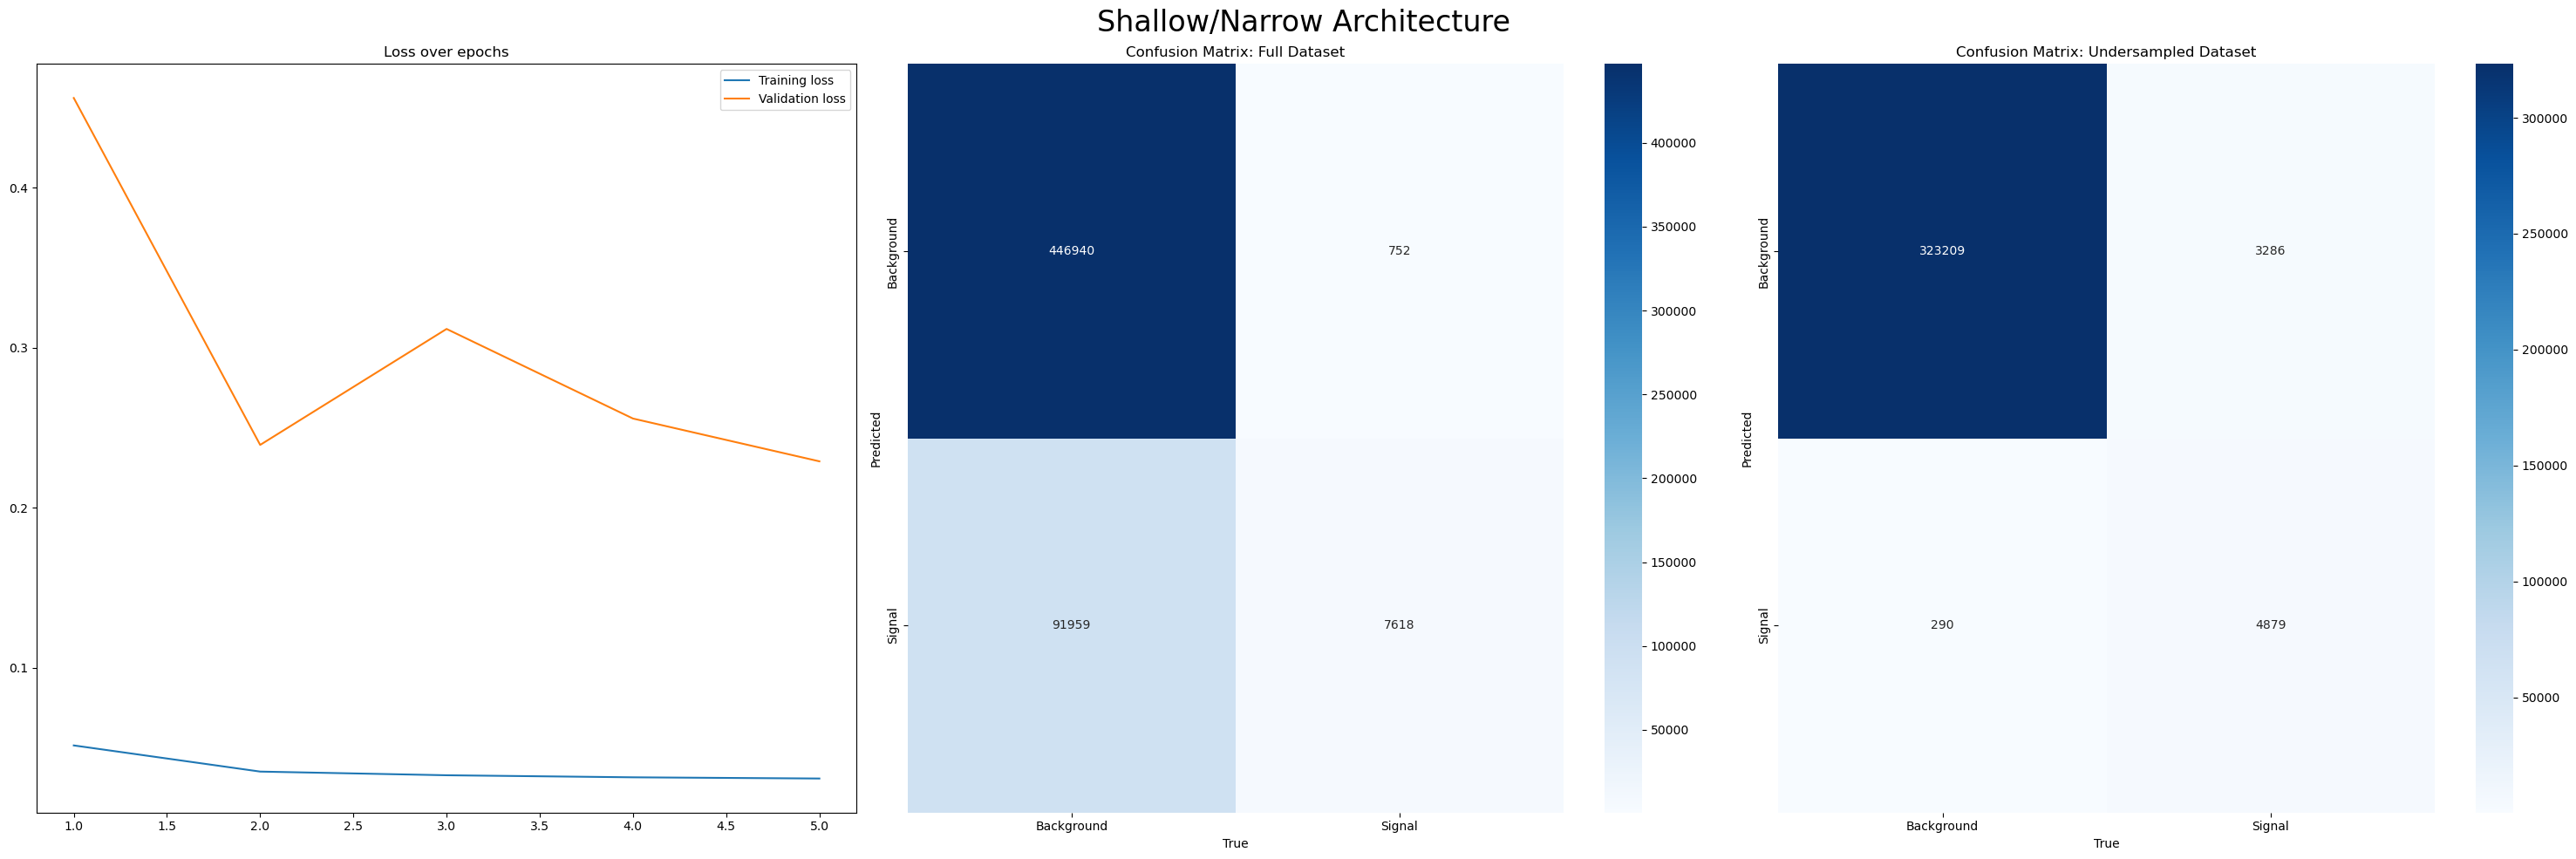

In [21]:
plot_model_performance(model=shallow_narrow_model, model_name="Shallow/Narrow", train_loss=shallow_narrow_train_losses, val_loss=shallow_narrow_val_losses)

Accuracy Calculation: DeepNarrowModel: 100%|██████████| 17103/17103 [00:07<00:00, 2383.48it/s]


Full Dataset Test Accuracy: 77.71%


Accuracy Calculation: DeepNarrowModel: 100%|██████████| 10365/10365 [00:04<00:00, 2233.95it/s]


Undersampled Dataset Test Accuracy: 98.97%


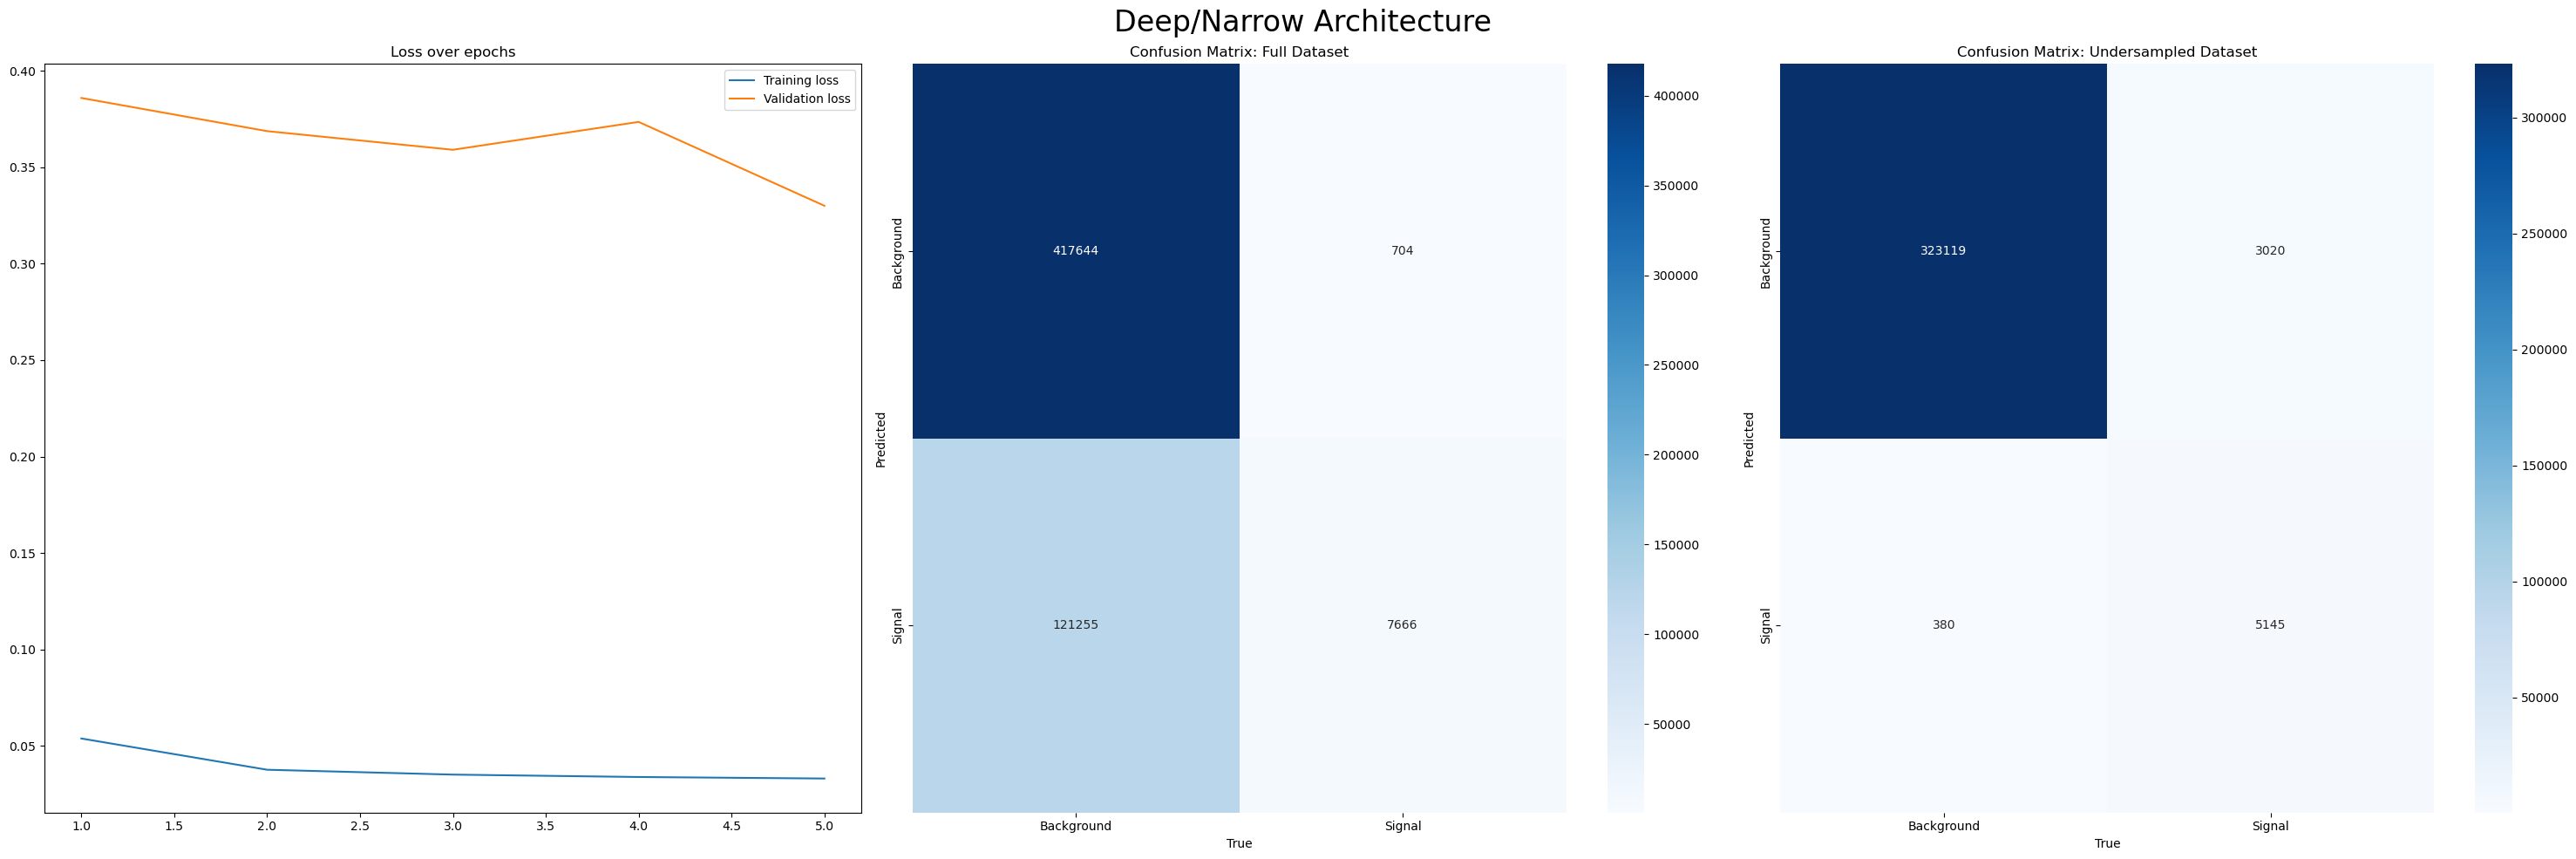

In [22]:
plot_model_performance(model=deep_narrow_model, model_name="Deep/Narrow", train_loss=deep_narrow_train_losses, val_loss=deep_narrow_val_losses)

Accuracy Calculation: DeepWideModel: 100%|██████████| 17103/17103 [00:12<00:00, 1389.05it/s]


Full Dataset Test Accuracy: 69.07%


Accuracy Calculation: DeepWideModel: 100%|██████████| 10365/10365 [00:06<00:00, 1487.57it/s]


Undersampled Dataset Test Accuracy: 98.94%


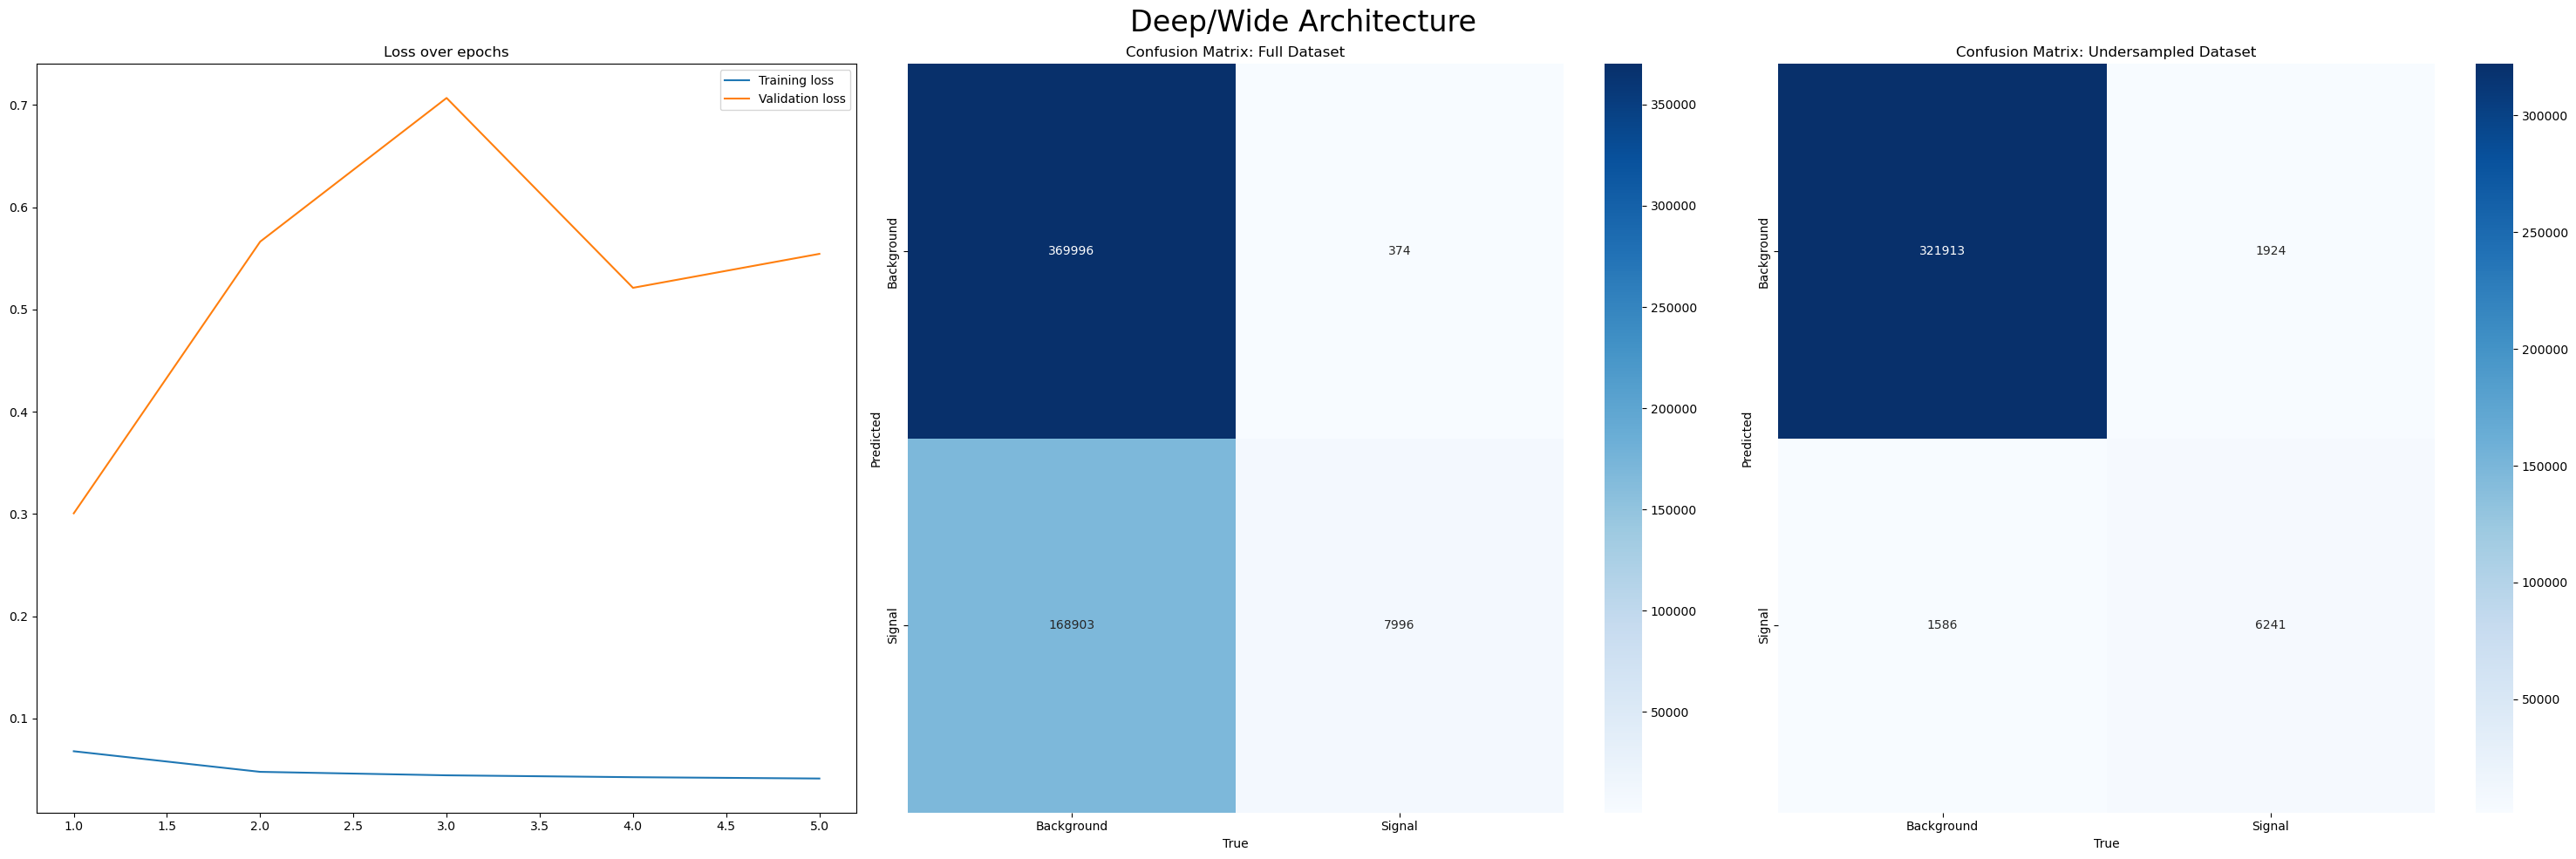

In [23]:
plot_model_performance(model=deep_wide_model, model_name="Deep/Wide", train_loss=deep_wide_training_losses, val_loss=deep_wide_val_losses)

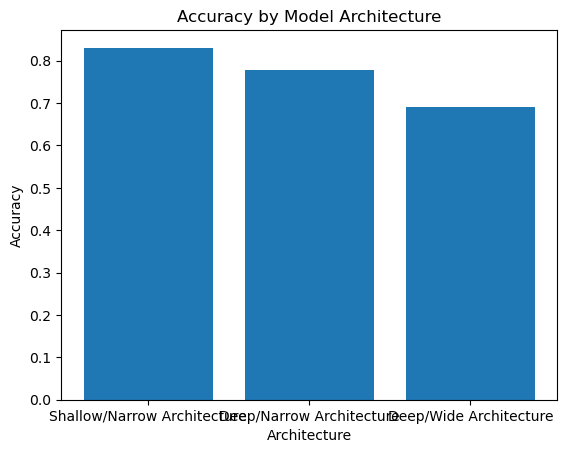

In [24]:
keys = list(accuracies.keys())
values = list(accuracies.values())

plt.bar(keys, values)

plt.xlabel('Architecture')
plt.ylabel('Accuracy')
plt.title('Accuracy by Model Architecture')

plt.show()